In [15]:
#!pip install imblearn

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [16]:
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf

In [17]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model, Sequential
from keras import regularizers
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE, ADASYN

In [18]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
train_df = train_df.drop(["ID_code"], axis=1)

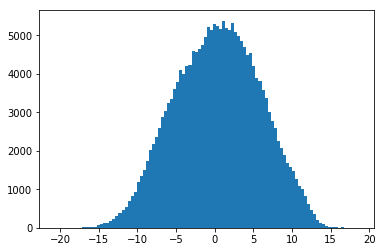

In [19]:
v = 10
plt.hist(train_df["var_" + str(v)], bins=100)
plt.show()

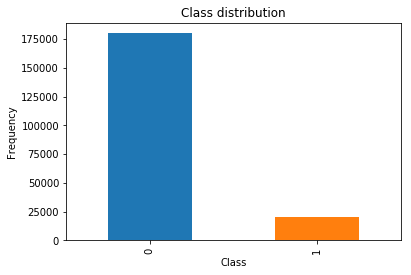

0    179902
1     20098
Name: target, dtype: int64

In [20]:
pd.value_counts(train_df["target"]).plot.bar()
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
train_df["target"].value_counts()

In [21]:
X = np.array(train_df.loc[:, train_df.columns != "target"])
y = np.array(train_df.loc[:, train_df.columns == "target"])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (200000, 200)
Shape of y: (200000, 1)


In [22]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of y_val: {}".format(y_val.shape))

Shape of X_train: (160000, 200)
Shape of y_train: (160000, 1)
Shape of X_val: (40000, 200)
Shape of y_val: (40000, 1)


In [23]:
def get_oversampling_model(typ=1):
    if typ == 1:
        print("SMOTE")
        return SMOTE(random_state=2)
    elif typ == 2:
        print("ADASYN")
        return ADASYN(random_state=2)
    else:
        print("SMOTE")
        return SMOTE(random_state=2)

In [24]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

os_mod = get_oversampling_model(typ = 1)
X_train_sam, y_train_sam = os_mod.fit_sample(X_train, y_train.ravel())

print("After OverSampling, the shape of train_X: {}".format(X_train_sam.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_sam.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_sam==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_sam==0)))

Before OverSampling, counts of label '1': [16084]
Before OverSampling, counts of label '0': [143916] 

SMOTE
After OverSampling, the shape of train_X: (287832, 200)
After OverSampling, the shape of train_y: (287832,) 

After OverSampling, counts of label '1': 143916
After OverSampling, counts of label '0': 143916


In [25]:
def get_model(ip_dim, layer_size = 200, drop_out = 0.2, learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, activation = "relu"):
    model = Sequential()
    
    # Layer 1
    model.add(Dense(layer_size, input_dim = ip_dim))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(drop_out))
            
    # Layer 2
    model.add(Dense(layer_size))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(drop_out))
    
    # Layer 3
    model.add(Dense(layer_size))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(drop_out))
        
    # Layer 4
    model.add(Dense(layer_size))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(drop_out))
    
    # Layer 5
    model.add(Dense(layer_size))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(drop_out))
    
    # Output Layer
    model.add(Dense(1, activation="sigmoid"))
    
    # Adam optimizer
    adam = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=0.0)
    
    model.compile(optimizer=adam, metrics = ["accuracy"], loss="binary_crossentropy")
    return model

In [26]:
model_nn = get_model(X_train_sam.shape[1], layer_size = 200, drop_out = 0.3, learning_rate = 0.01, activation = "selu")
callback = EarlyStopping(monitor="val_acc", patience=5, verbose=1, mode="max")
history = model_nn.fit(X_train_sam, y_train_sam, validation_data = (X_val, y_val), epochs=10, batch_size=128, verbose=1, callbacks=[callback])

Train on 287832 samples, validate on 40000 samples
Epoch 1/10
287832/287832 [==============================] - 41s 141us/step - loss: 0.4247 - acc: 0.8105 - val_loss: 0.2789 - val_acc: 0.8955
Epoch 2/10
287832/287832 [==============================] - 37s 129us/step - loss: 0.3524 - acc: 0.8493 - val_loss: 0.4777 - val_acc: 0.7901
Epoch 3/10
287832/287832 [==============================] - 38s 130us/step - loss: 0.3250 - acc: 0.8630 - val_loss: 0.3313 - val_acc: 0.8686
Epoch 4/10
287832/287832 [==============================] - 38s 132us/step - loss: 0.3070 - acc: 0.8715 - val_loss: 0.3007 - val_acc: 0.8848
Epoch 5/10
287832/287832 [==============================] - 37s 127us/step - loss: 0.2921 - acc: 0.8787 - val_loss: 0.3549 - val_acc: 0.8527
Epoch 6/10
287832/287832 [==============================] - 39s 134us/step - loss: 0.2830 - acc: 0.8827 - val_loss: 0.3092 - val_acc: 0.8819
Epoch 00006: early stopping


In [27]:
y_val_pred = model_nn.predict(X_val)
#tn, fp, fn, tp = confusion_matrix(y_val, (y_val_prob>0.5)*1).ravel()
#print("tn:", tn, "fp:", fp, "fn:", fn, "tp", tp)
#print("Precision Score:", tp/(fp + tp), "Specificity Score:", tn/(tn+fp), "Recall Score:", tp/(fn+tp))
fpr, tpr, thresholds = roc_curve(y_val, (y_val_pred>0.5)*1)
print("ROC Score: {}".format(roc_auc_score(y_val, (y_val_pred>0.5)*1)))

ROC Score: 0.6566101205664574


In [28]:
X_test = np.array(test_df.loc[:, test_df.columns != "ID_code"])
y_pred = model_nn.predict(X_test)

In [29]:
submit = pd.DataFrame() 
submit["ID_code"] = test_df["ID_code"] 
submit["target"] = (y_pred>0.5)*1
submit.to_csv("../submission.csv", index=False)